<a href="https://colab.research.google.com/github/TamaDioo/Pembelajaran-Mesin/blob/main/TG1_2_3_JS15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jobsheet 15 - Machine Learning Pipeline & Deployment

Nama: Dio Andika Pradana Mulia Tama

NIM: 2341720098

Kelas: TI-3F

# Lab 1
Klasifikasi Citra Days vs. Nights dengan NN

## Membangun & Ekspor Model
Pada praktikum bagian pertama ini, kita akan melatih model dan menyimpan "artefak" (file hasil training) yang dibutuhkan untuk deployment. Dengan melakukan Klasifikasi Gambar (Day vs Night) mengunakan Neural Network.

### Langkah 1: Import Library dan Mount Google Drive

Langkah pertama adalah mengimpor pustaka yang diperlukan untuk pengolahan citra, *machine learning*, dan *deep learning*, serta menghubungkan Google Colab dengan Google Drive.

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Langkah 2: Load Dataset

Membaca gambar dari direktori *training* dan *testing*, lalu menyimpannya dalam list bersama dengan labelnya.

Catatan: Sesuaikan path dengan lokasi folder `images` di Google Drive Anda masing-masing.

In [ ]:
# Load images and labels from a directory structure
def load_dataset(img_dir):
    p = Path(img_dir)
    img_list = []
    for folder in p.glob('*'):
        label = folder.name
        for file in folder.glob('*.jpg'):
            img = cv2.imread(str(file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_list.append((img, label))
    return img_list

train_dir = "/content/drive/MyDrive/dataset/images/training/"
test_dir  = "/content/drive/MyDrive/dataset/images/test"

train_img = load_dataset(train_dir)
test_img  = load_dataset(test_dir)

print(f"Jumlah data training: {len(train_img)}")
print(f"Jumlah data testing: {len(test_img)}")

Jumlah data training: 240
Jumlah data testing: 160


### Langkah 3: Preprocessing (Resize & Label Encoding)

Mengubah ukuran gambar menjadi 256x256 piksel dan mengubah label teks ('day'/'night') menjadi angka biner (1/0).

In [ ]:
# Preprocess images: resize and encode labels
def resize_image(img, size=(256,256)):
    return cv2.resize(img, size)

def label_encoder(label):
    return 1 if label == 'day' else 0

def preprocess(img_list):
    X = []
    y = []
    for img, label in img_list:
        img_std = resize_image(img)
        X.append(img_std)
        y.append(label_encoder(label))
    return X, y

X_train_img, y_train = preprocess(train_img)
X_test_img,  y_test  = preprocess(test_img)

### Langkah 4: Ekstraksi Fitur HOG (Histogram of Oriented Gradients)

Mengekstraksi fitur bentuk dan tekstur dari gambar menggunakan metode HOG.

In [ ]:
# Extract HOG features
def extract_hog(X_imgs):
    feats = []
    for img in X_imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray,
                       orientations=9,
                       pixels_per_cell=(8,8),
                       cells_per_block=(2,2),
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
        feats.append(hog_feat)
    return np.array(feats)

X_train_feat = extract_hog(X_train_img)
X_test_feat  = extract_hog(X_test_img)

### Langkah 5: Normalisasi Fitur

Menstandarisasi fitur agar memiliki rata-rata 0 dan variansi 1 menggunakan `StandardScaler`.

In [ ]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)

### Langkah 6: Split Data Training & Validation

Memisahkan data *training* menjadi data *train* dan *validation*.

In [ ]:
# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42
)

### Langkah 7: Konversi Label ke Numpy Array

Mengubah list label menjadi format *numpy array* agar kompatibel dengan TensorFlow/Keras.

In [ ]:
# Convert labels to numpy arrays (required for Keras)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

### Langkah 8: Membangun Arsitektur Model Neural Network

Membuat model *Sequential* dengan 3 layer (Input, Hidden Layers dengan ReLU, dan Output Layer dengan Sigmoid).

In [ ]:
# Build a simple feedforward neural network
# Define model architecture
# input_dim is the number of features in the dataset
# Hidden layer -> 128 neurons, ReLU activation
# Hidden layer -> 64 neurons, ReLU activation
# Output layer -> 1 neuron, Sigmoid activation (for binary classification)
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     4,428,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,737 (16.92 MB)

 Trainable params: 4,436,737 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

### Langkah 9: Training Model

Melatih model menggunakan data *training* selama 20 epoch.

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 567ms/step - accuracy: 0.7108 - loss: 1.2107 - val_accuracy: 0.9375 - val_loss: 0.1813
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.9961 - loss: 0.0311 - val_accuracy: 0.9792 - val_loss: 0.0756
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.9856 - loss: 0.1097 - val_accuracy: 0.9583 - val_loss: 0.2460
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9915 - loss: 0.0389 - val_accuracy: 0.9792 - val_loss: 0.1986
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9985 - loss: 0.0176 - val_accuracy: 0.9375 - val_loss: 0.1704
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 1.4507e-04 - val_accuracy: 1.0000 - val_loss: 0.0120
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 2.6484e-04 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 1.1303e-05 - val_accuracy: 1.0000 -

### Langkah 10: Evaluasi Model

Menguji performa model pada data *testing*.

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print("Akurasi Test:", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7889 - loss: 2.6865
Akurasi Test: 0.856249988079071


### Langkah 11: Prediksi dan Laporan Klasifikasi serta Visualisasi

Membuat prediksi pada data *test* dan menampilkan *classification report* serta *confusion matrix*.

In [ ]:
# Generate classification report and confusion matrix
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        80
           1       0.94      0.76      0.84        80

    accuracy                           0.86       160
   macro avg       0.87      0.86      0.85       160
weighted avg       0.87      0.86      0.85       160

[[76  4]
 [19 61]]


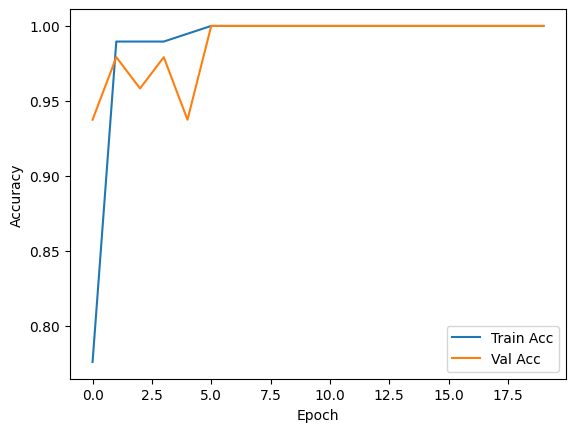

In [ ]:
# Visualize training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Langkah 12: Menyimpan Model dan Scaler

Menyimpan model yang sudah dilatih ke dalam format `.h5` dan scaler ke format `.pkl` untuk penggunaan deployment.

In [ ]:
# Save the trained model
import pickle

# 1. Simpan Model
# Menggunakan format .h5
model.save('day_night_model.h5')
print("✅ Model berhasil disimpan sebagai: day_night_model.h5")

# 2. Simpan Scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler berhasil disimpan sebagai: scaler.pkl")

✅ Model berhasil disimpan sebagai: day_night_model.h5
✅ Scaler berhasil disimpan sebagai: scaler.pkl


# Lab 2
Deployment ke Hugging Face (Docker + Flask)

## Deskripsi
Pada praktikum ini, mahasiswa akan melakukan siklus lengkap pengembangan Machine Learning (MLOps sederhana). Mahasiswa setelah melatih model klasifikasi gambar (Day vs Night) menggunakan ekstraksi fitur HOG dan Neural Network dan mengekspor model tersebut, selanjutnya pada praktikum 2 ini adalah melakukan deploy ke server cloud Hugging Face menggunakan Docker container.

## Tujuan
Setelah menyelesaikan praktikum ini, mahasiswa diharapkan mampu:
1. Membuat aplikasi web server menggunakan Flask.
2. Mengkonfigurasi Docker container untuk lingkungan ML.
3. Melakukan deployment aplikasi ke Hugging Face Spaces menggunakan Git CLI.

### Langkah 1: Persiapan Environment

Langkah pertama adalah menyiapkan struktur direktori kerja dan memastikan file model tersedia.
1. Buat folder baru di komputer Anda dengan nama `daynight-project`.
2. Cari file model (`day_night_model.h5`) dan scaler (`scaler.pkl`) hasil training dari praktikum sebelumnya.
3. Pindahkan kedua file tersebut ke dalam folder `daynight-project`.
4. Buka terminal (Git Bash atau CMD), lalu arahkan direktori ke folder tersebut.

### Langkah 2: Konfigurasi Server (`app.py`)

Diperlukan aplikasi web sederhana menggunakan Flask untuk menangani *request* gambar dari pengguna.

1. Buat file baru bernama `app.py` di dalam folder proyek.
2. Salin kode berikut ke dalamnya (kode ini memuat model dan melakukan preprocessing HOG yang sama persis dengan saat training):

In [ ]:
import os
import numpy as np
import cv2
import pickle
import tensorflow as tf
from flask import Flask, request, render_template_string
from skimage.feature import hog

app = Flask(__name__)

# Load Model & Scaler
MODEL_PATH = 'day_night_model.h5'
SCALER_PATH = 'scaler.pkl'

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    with open(SCALER_PATH, 'rb') as f:
        scaler = pickle.load(f)
    print("✅ System Loaded Successfully")
except Exception as e:
    print(f"❌ Error loading system: {e}")

def preprocess_image(image_bytes):
    # Decode gambar
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Preprocessing (Harus sama persis dengan Training)
    img = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8,8),
                   cells_per_block=(2,2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    return scaler.transform(hog_feat.reshape(1, -1))

@app.route('/', methods=['GET'])
def home():
    return render_template_string('''
    <div style="text-align:center; padding:50px;">
        <h1>Day vs Night Classifier</h1>
        <form action="/predict" method="post" enctype="multipart/form-data">
            <input type="file" name="file" required><br><br>
            <button type="submit">Prediksi</button>
        </form>
    </div>
    ''')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        file = request.files['file']
        data = preprocess_image(file.read())
        prediction = model.predict(data)[0][0]

        label = "Day (Siang)" if prediction > 0.5 else "Night (Malam)"
        return f"<h2 style='text-align:center'>Hasil: {label}</h2><center><a href='/'>Kembali</a></center>"
    except Exception as e:
        return f"Error: {e}"

if __name__ == '__main__':
    # Port 7860 wajib untuk Hugging Face Spaces
    app.run(host='0.0.0.0', port=7860)

✅ System Loaded Successfully
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:7860
 * Running on http://172.28.0.12:7860
INFO:werkzeug:Press CTRL+C to quit


## Langkah 3: Konfigurasi Dependencies (`requirements.txt`)

Agar server cloud tahu library apa saja yang dibutuhkan, perlu membuat daftar dependencies.
1. Buat file baru bernama `requirements.txt`.
2. Isi file tersebut dengan daftar library berikut:

In [ ]:
flask
tensorflow-cpu
numpy
scikit-learn
scikit-image
opencv-python-headless
gunicorn

### Langkah 4: Konfigurasi Docker (`Dockerfile`)
Dockerfile berisi instruksi untuk membangun *image* sistem operasi yang akan menjalankan aplikasi kita.
1. Buat file bernama `Dockerfile` (tanpa ekstensi file apapun).
2. Salin konfigurasi berikut:

In [ ]:
# Base Image Python 3.9 Slim
FROM python:3.9-slim

# Install Library Sistem untuk OpenCV (Debian Bookworm/Trixie Compatible)
RUN apt-get update && apt-get install -y \
    libgl1 \
    libglib2.0-0 \
    && rm -rf /var/lib/apt/lists/*

# Setup User Non-Root (Standar Keamanan HF)
RUN useradd -m -u 1000 user
USER user
ENV PATH="/home/user/.local/bin:$PATH"

# Setup Direktori Kerja
WORKDIR /app

# Install Dependencies
COPY --chown=user ./requirements.txt requirements.txt
RUN pip install --no-cache-dir --upgrade -r requirements.txt

# Copy File Aplikasi
COPY --chown=user . /app

# Expose Port & Jalankan
EXPOSE 7860
CMD ["python", "app.py"]

### Langkah 5: Setup Hugging Face Space

Sekarang perlu membuat wadah untuk aplikasi ini di Hugging Face.

### Langkah 6: Upload ke Cloud (Hugging Face)

Pada langkah ini, akan dilakukan dengan cara men-download repository kosong dari Hugging Face ke komputer, mengisi file-nya, lalu mengunggahnya kembali.

### Langkah 7: Pengujian dan Hasil Akhir

https://huggingface.co/spaces/TamaDio/daynight-classifier-dioandika2341720098

# Tugas Lab

Setelah berhasil melakukan deployment pada studi kasus latihan ("Day vs Night"), tugas Anda selanjutnya adalah menerapkan pipeline deployment yang sama untuk model Project anda masing-masing.

1. Pastikan Anda memiliki file hasil training dari Google Colab/Jupyter Notebook Anda:
    - File Model (`.h5`): Model yang sudah dilatih dengan akurasi terbaik.
    - File Scaler (`.pkl`)
2. Anda harus membuat file `app.py` yang sesuai dengan logika model Anda.
3. Lakukan langkah deployment standar:
    - Siapkan Folder: Buat folder baru, masukkan `app.py`, model `.h5`, dan scaler `.pkl`.
    - Requirements.txt: Pastikan isinya sesuai library yang dipakai.
    - Dockerfile: Gunakan konfigurasi Dockerfile standar dari praktikum sebelumnya.
    - Create Space: Buat Space baru di Hugging Face.
    - Git Process:
      - `git clone` repository space baru Anda.
      - Copy semua file ke folder clone.
      - `git add`, `git commit`, `git push`.



## Link Hungging Face Tugas Lab:
https://huggingface.co/spaces/TamaDio/batiknitik-classifier-dioandika